In [1]:
# import theano as tn

In [2]:
import keras

Using TensorFlow backend.


In [3]:
# import tensorflow as tf

In [4]:
# tf.__version__

In [5]:
# reload(tf)

In [6]:
data = pd.read_hdf('data_moriond_v9.hd5')

In [7]:
mc = pd.read_hdf('mc_moriond_v9.hd5')

In [8]:
data.shape

(21216525, 26)

In [9]:
mc.shape

(11554790, 25)

In [10]:
data = data.query('abs(ScEta) < 1.5')
mc = mc.query('abs(ScEta) < 1.5')

In [11]:
data.shape

(17520217, 26)

In [12]:
mc.shape

(9616192, 25)

In [13]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [14]:
# y_features = ['SigmaRR', 'CovarianceIetaIphi','PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'SigEOverE']
y_features = ['CovarianceIetaIphi','PhoIso03', 'ChIso03', 'ChIso03worst', 'SigEOverE']

In [15]:
x_features = ['Pt','ScEta','Phi','rho']
x_noise = []

for inoise in range(len(y_features)):
    iname = 'noise%d' % inoise
    mc[iname] = np.random.normal(0.,1.,mc.shape[0])
    x_noise.append(iname)


In [16]:
X_mc = mc[y_features+x_features].values.astype(np.float32)
X_data = data[y_features+x_features].values.astype(np.float32)

from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer
# scaler = RobustScaler()
# scaler = MinMaxScaler((-1,1))
scaler = QuantileTransformer(output_distribution='normal')

X_mc = scaler.fit_transform(X_mc).reshape((-1,len(x_features+y_features),1,1))
X_data = scaler.transform(X_data).reshape((-1,len(x_features+y_features),1,1))


y_mc = X_mc[:,:len(y_features)]
y_data = X_data[:,:len(y_features)]

X_mc = np.hstack( [X_mc, mc[x_noise].values.reshape((-1,len(x_noise),1,1))]  )


In [17]:
import models

In [18]:
reload(models)

discriminator = models.get_discriminator(y_mc.shape[1:])

generator = models.get_generator(X_mc.shape[1:],y_mc.shape[1:],filt_size=[16,32,64,128])#,filt_size=[8,16,32])



2 32 14
1 1 1
True
(None, 32, 1, 16) (2, 1)
(None, 16, 1, 32) (2, 1)
(None, 8, 1, 64) (2, 1)
(None, 4, 1, 128) (2, 1)


In [19]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 14, 1, 1)      0                                            
____________________________________________________________________________________________________
G_padding (ZeroPadding2D)        (None, 32, 1, 1)      0           input_2[0][0]                    
____________________________________________________________________________________________________
G_cunit_16_bn0 (BatchNormalizati (None, 32, 1, 1)      4           G_padding[0][0]                  
____________________________________________________________________________________________________
G_cunit_16_conv0 (Conv2D)        (None, 32, 1, 16)     32          G_cunit_16_bn0[0][0]             
___________________________________________________________________________________________

In [20]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 1, 1)           0         
_________________________________________________________________
D_conv32_conv (Conv2D)       (None, 5, 1, 32)          64        
_________________________________________________________________
D_conv32_actv (LeakyReLU)    (None, 5, 1, 32)          0         
_________________________________________________________________
D_conv32_dout (Dropout)      (None, 5, 1, 32)          0         
_________________________________________________________________
D_conv64_conv (Conv2D)       (None, 5, 1, 64)          2112      
_________________________________________________________________
D_conv64_actv (LeakyReLU)    (None, 5, 1, 64)          0         
_________________________________________________________________
D_conv64_dout (Dropout)      (None, 5, 1, 64)          0         
__________

In [21]:
from IPython.display import SVG
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import model_to_dot

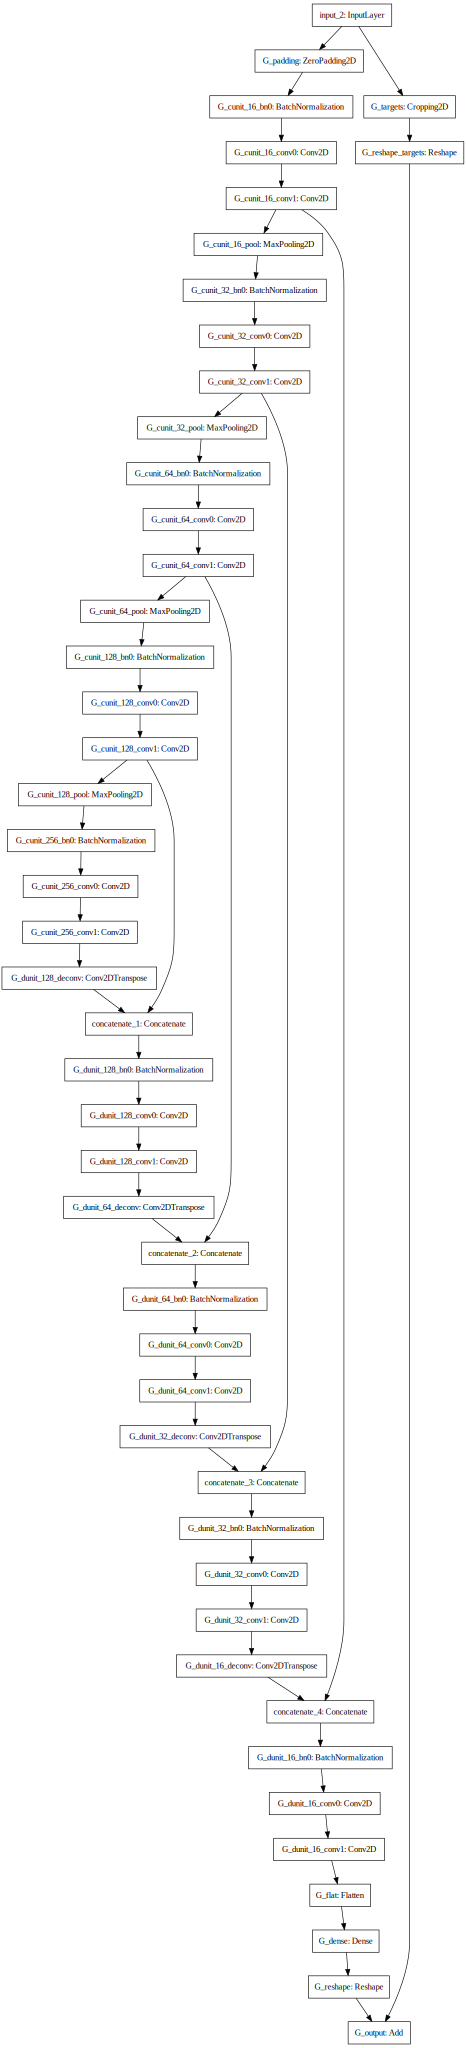

In [22]:
SVG(model_to_dot(generator).create(prog='dot', format='svg'))

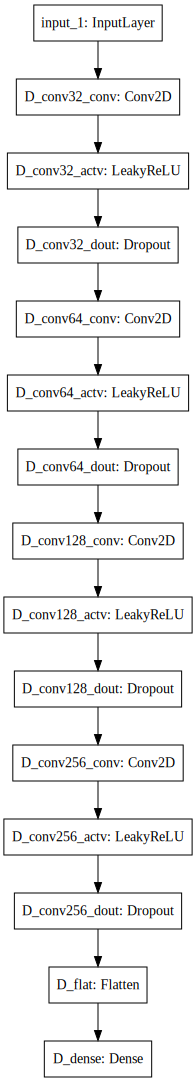

In [23]:
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

In [24]:
# from keras.optimizers import Adam
# generator.compile(optimizer=Adam(lr=1e-3), loss='mean_squared_error')


In [25]:
# generator.fit(X_mc[:1000000],y_mc[:1000000])

In [26]:
reload(models)

dm = models.discriminator_model(discriminator)
am = models.adversarial_model(generator,discriminator)

In [ ]:
from sklearn.utils import shuffle 

train_steps = 5

batch_size = 1024
n_batches = 1000000 // batch_size

# n_batches = 100 

print(n_batches)

def train_batch(ib,batch_size):
    X_mc_batch = X_mc[ib*batch_size:(ib+1)*batch_size]
    y_mc_batch = y_mc[ib*batch_size:(ib+1)*batch_size]
    y_data_batch = y_data[ib*batch_size:(ib+1)*batch_size]

    y_mc_corr = generator.predict(X_mc_batch)
    x_disc = np.concatenate( [y_mc_corr,y_data_batch] )
    y_disc = np.ones( (x_disc.shape[0],1) )
    y_disc[y_mc_corr.shape[0]:, :] = 0
    # x_disc,y_disc = shuffle( x_disc,y_disc )
    
    discriminator.trainable = True 
    d_loss = dm.train_on_batch(x_disc, y_disc)
    discriminator.trainable = False
    a_loss = am.train_on_batch(X_mc_batch, np.ones(X_mc_batch.shape[0]))


for i in range(train_steps):   
    %time for ib in range(n_batches): train_batch(ib,batch_size)
        
    # print(".")
#         log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
#         log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
        
#         print(log_mesg)
        
#     noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
#     images_fake = self.generator.predict(noise)
#     x = np.concatenate((images_train, images_fake))
#     y = np.ones([2*batch_size, 1])
#     y[batch_size:, :] = 0
#     self.discriminator.trainable = True
#     d_loss = self.discriminator.train_on_batch(x, y)

#     y = np.ones([batch_size, 1])
#     noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
#     self.discriminator.trainable = False
#     a_loss = self.adversarial.train_on_batch(noise, y)
#     log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
#     log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
#     print(log_mesg)
#     if save_interval>0:
#         if (i+1)%save_interval==0:
#             self.plot_images(save2file=True, samples=noise_input.shape[0],\
#                 noise=noise_input, step=(i+1))


976


In [66]:
y_mc_corr = generator.predict(X_mc[:100000])

CovarianceIetaIphi


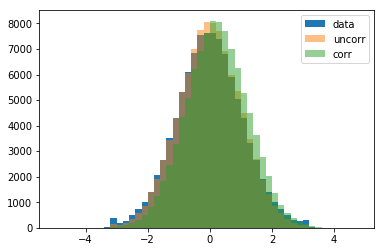

PhoIso03


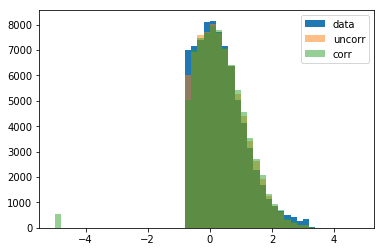

ChIso03


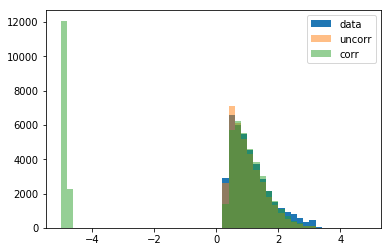

ChIso03worst


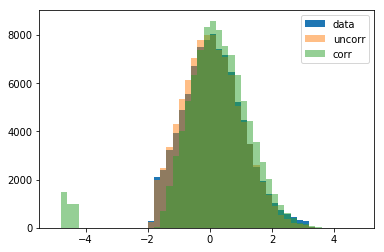

SigEOverE


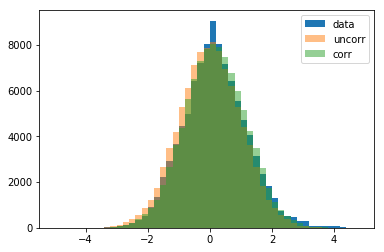

In [67]:
for ivar,var in enumerate(y_features):
    print(var)
    var_mc_uncorr = y_mc[:100000,ivar].ravel()
    var_mc_corr = y_mc_corr[:,ivar].ravel()
    var_data = y_data[:100000,ivar].ravel()
    #bins = np.percentile(  np.hstack([var_mc_uncorr,var_data]), np.arange(0,105,5)  )
    bins = np.arange(-5,5,0.2)
    plt.hist(var_data,bins=bins,label='data')
    plt.hist(var_mc_uncorr,bins=bins,alpha=0.5,label='uncorr')
    plt.hist(var_mc_corr,bins=bins,alpha=0.5,label='corr')
    plt.legend()
    plt.show()


In [68]:
y_data[:,1].mean()

-0.7717604

In [69]:
len(y_features)

5

In [70]:
np.arange(0,105,5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])